In [2]:
from kubernetes import client, config
import json
import matplotlib.pyplot as plt
import numpy as np

In [3]:
config.load_kube_config()
graph_dir = "graphs/"

# Consensus Stats

In [4]:
stats_name = ['msg rcv total',
              'msg sent total',
              'comp time per iter',
              'xchg time per iter',
              'avg time per iter',
              'total time',
              'total iter',
              'setup time']

In [5]:
def read_metrics():
    metrics = {}

    v1 = client.CoreV1Api()
    ret = v1.list_pod_for_all_namespaces(watch=False)
    for i in ret.items:
        if i.metadata.name.startswith("my-scheduler-") or i.metadata.name.startswith("my-controller"):
            # print(f"{i.metadata.name} {i.status.pod_ip}")
            lines = v1.read_namespaced_pod_log(
                name=i.metadata.name, namespace=i.metadata.namespace)

            name = i.metadata.name
            if name.startswith('my-scheduler-'):
                metrics[name] = {}
            for line in lines.split('\n'):
                if name.startswith('my-sched') and line.startswith('{'):
                    d = json.loads(line)
                    for sn in stats_name:
                        if sn.endswith('per iter'):
                            if not sn in metrics[name]:
                                metrics[name][sn] = []
                            if sn in d:
                                metrics[name][sn].append(d[sn])
                        else:
                            if sn in d:
                                metrics[name][sn] = d[sn]
    return metrics

## stats per pod

Plot stats, large variance in computation time per iteration is perhaps due to the
short period of computation leading to incorrect timing measurement

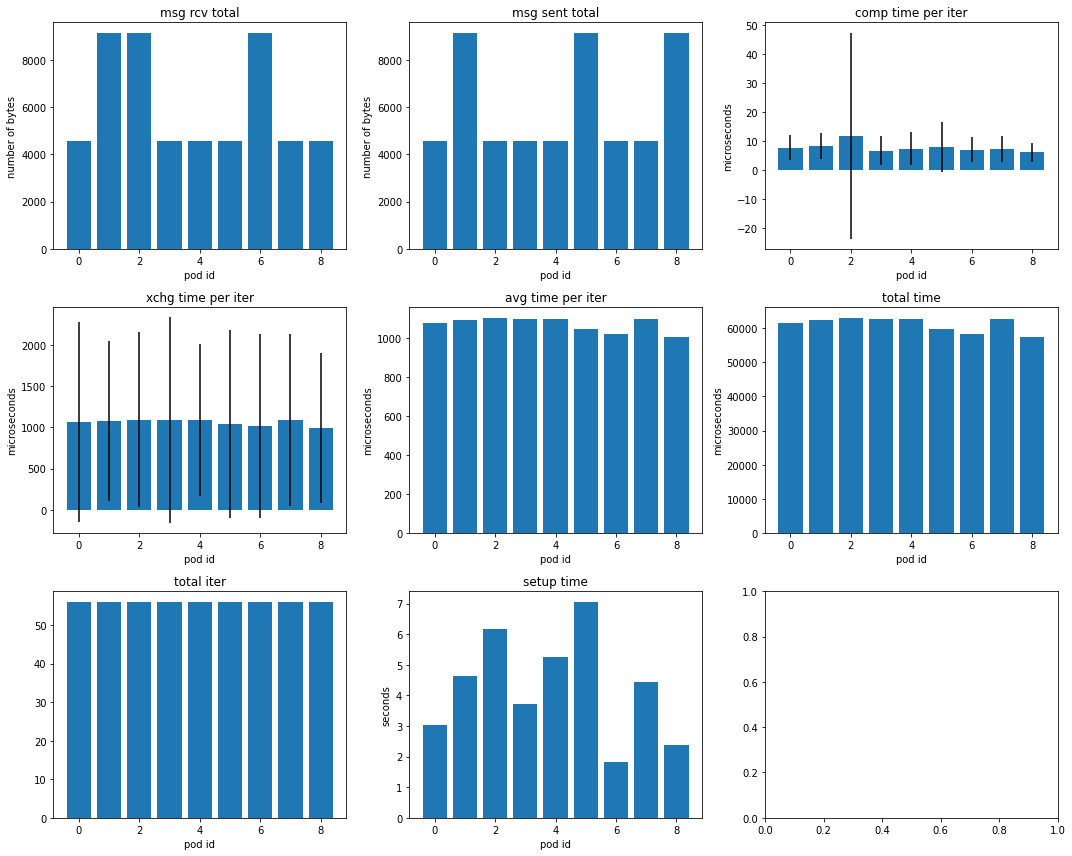

In [10]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(15, 12)

x = range(len(metrics.keys()))


for i, sn in enumerate(stats_name):
    y = []
    a = ax[i // 3][i % 3]
    a.set_xlabel('pod id')
    if i in [0, 1]:
        a.set_ylabel('number of bytes')
    elif i in [2, 3, 4, 5]:
        a.set_ylabel("microseconds")

    if sn.find('total') != -1:
        for name in metrics:
            y.append(metrics[name][sn])
        a.bar(x, y)
        a.set_title(sn)

    elif sn.find('per iter') != -1:
        for name in metrics:
            d = np.array(metrics[name][sn])
            mean = np.mean(d)
            std = np.std(d)
            y.append([mean, std])
        y = np.array(y)
        a = ax[i // 3][i % 3]
        a.bar(x, y[:, 0], yerr = y[:, 1])
        a.set_title(sn)

    elif sn.find('setup time') != -1:
        for name in metrics:
            y.append(metrics[name]['fields.time'])
        a = ax[i // 3][i % 3]
        a.bar(x, y)
        a.set_title(sn)
        a.set_ylabel('seconds')


fig.tight_layout()
fig.savefig(f'{graph_dir}metrics-{p}pods.png')



## Stats against number of pods

In [45]:
dirs = ['data/2022-08-15T']
metrics = {}
pods = range(100, 1000, 100)
runs = range(11)
for p in pods:
  with open(f'data/data-{p}pods.json', 'r') as f:
    for line in f:
      metrics[p] = json.loads(line)
print(metrics[100]['0']['my-scheduler-c5648b7d-22lrq']['setup time'])

29.934439289


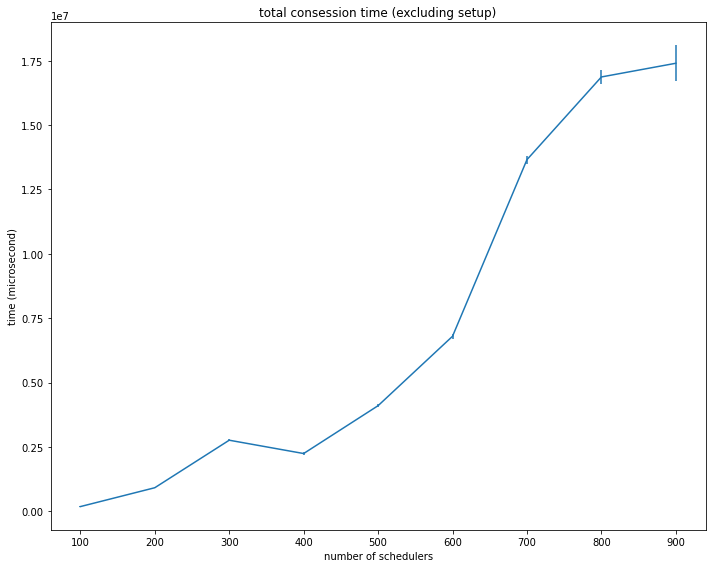

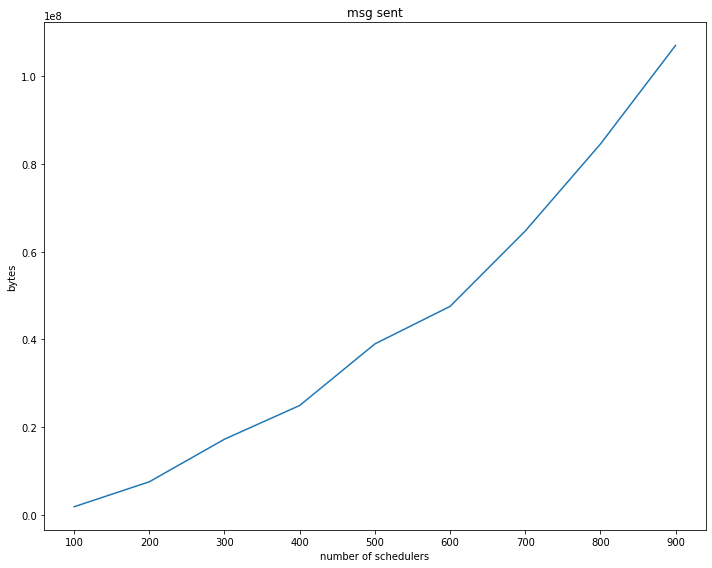

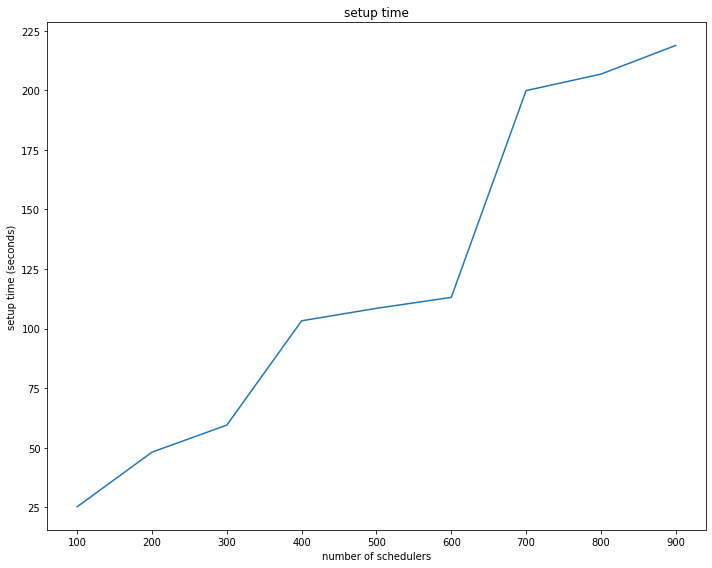

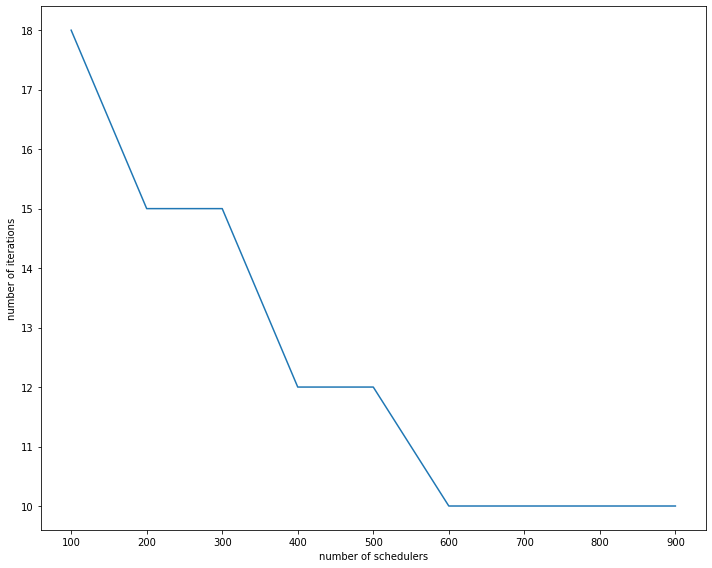

In [52]:

x = pods
y_time = []
y_msg_sent = []
y_setup = []
y_iter = []

for p in pods:
  t1 = []
  for r in runs:
    r = str(r)
    t2 = np.array([metrics[p][r][name]['total time'] for name in metrics[p][r]])
  t1.append(np.mean(t2))

  y_time.append([np.mean(t2), np.std(t2)])

  t1 = []
  for r in runs:
    r = str(r)
    t2 = np.array([metrics[p][r][name]['msg sent total'] for name in metrics[p][r]])
  t1.append(np.sum(t2))
  y_msg_sent.append([np.mean(t1), np.std(t1)])

  t2 = np.array([metrics[p]['0'][name]['setup time'] for name in metrics[p][r]])
  y_setup.append(np.mean(t2))


  t2 = np.array([metrics[p]['0'][name]['total iter'] for name in metrics[p][r]])
  y_iter.append(np.mean(t2))


  
y_time = np.array(y_time)
y_msg_sent = np.array(y_msg_sent)



fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

# -------- latency --------- #

ax.errorbar(x, y_time[:, 0], yerr = y_time[:, 1])
ax.set_title('total consensus time (excluding setup)')
ax.set_xlabel('number of schedulers')
ax.set_ylabel('time (microsecond)')

fig.tight_layout()
fig.savefig(f'{graph_dir}latency.png')

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

# -------- msg sent --------- #

ax.errorbar(x, y_msg_sent[:, 0], yerr = y_msg_sent[:, 1])
ax.set_title('msg sent')
ax.set_xlabel('number of schedulers')
ax.set_ylabel('bytes')

fig.tight_layout()
fig.savefig(f'{graph_dir}message.png')


# -------- setup time --------- #

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.plot(x, y_setup)
ax.set_title('setup time')
ax.set_xlabel('number of schedulers')
ax.set_ylabel('setup time (seconds)')
fig.tight_layout()
fig.savefig(f'{graph_dir}setup_time.png')


#------ iteration -------- #
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.plot(x, y_iter)
ax.set_xlabel('number of schedulers')
ax.set_ylabel('number of iterations')
fig.tight_layout()
fig.savefig(f'{graph_dir}iter.png')



## CPU and Memory

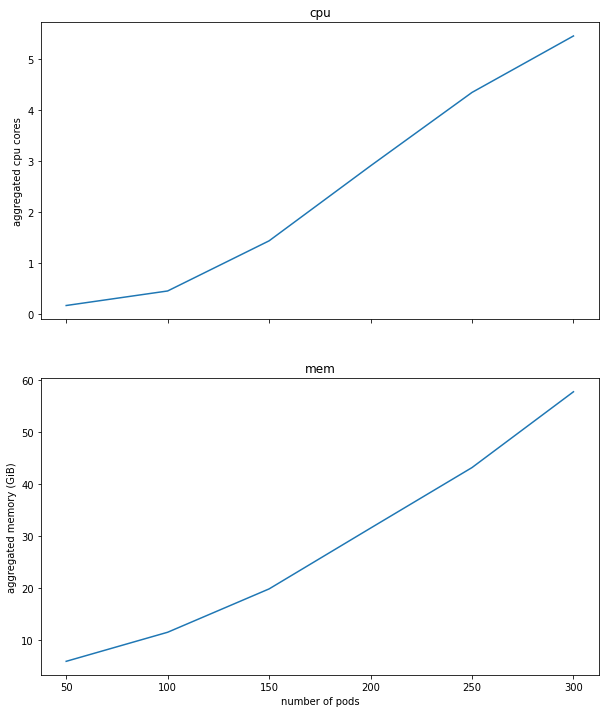

In [20]:
cpu = [0.17, 0.455, 1.438, 2.908, 4.347, 5.454]
mem = [5.97, 11.55, 19.87, 31.54, 43.16, 57.71]
pods = range(50, 350, 50)


fig, ax = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(10, 12)

ax[0].plot(pods, cpu, label='cpu')
ax[0].set_title('cpu')
ax[0].set_ylabel('aggregated cpu cores')

ax[1].plot(pods, mem, label='mem')
ax[1].set_title('mem')
ax[1].set_ylabel('aggregated memory (GiB)')
ax[1].set_xlabel('number of pods')

fig.savefig(f'{graph_dir}cpu-and-memory-usage.png')

# Placement Stats

## Capacity left

In [6]:
dirs = ['data/2022-08-16T11-19-32', 'data/2022-08-16T11-23-20', 'data/2022-08-16T11-27-08',
  'data/2022-08-16T11-31-12']
pl = [{} for _ in range(len(dirs))]
# dirs = ['data/2022-08-11T18-01-42/', 'data/2022-08-11T18-06-46/', 'data/2022-08-11T18-12-00/', 'data/2022-08-11T18-18-56/']
for i, dir in enumerate(dirs):
  with open(f'{dir}/placement-{(i+1) * 100}pods-60cap-2c.json', 'r') as f:
    for l in f:
      pl[i] = json.loads(l)

In [7]:
final_ws = []
left_elements = []
for i in range(len(dirs)):
  final_w = []
  for k, v in pl[i]['1'].items():
    if k == 'my-controller':
      left_elements.append(np.array(v['left elements']))
    else:
      final_w.append(v['final w'])
  final_ws.append(np.array(final_w))

print(final_ws)
print(f'sum is {np.sum(final_w)}')
print(f'mean is {np.mean(final_w)}')
print(f'std is {np.std(final_w)}')
print(f'elements left are {left_elements}')

[array([4.09821482, 0.08681597, 3.28481602, 0.43911476, 4.74178375,
       2.35477666, 0.46957574, 1.10506728, 0.33761239, 2.93952064,
       0.88459235, 2.41863239, 0.47904765, 1.18295194, 2.1669275 ,
       0.4507122 , 1.81234563, 1.33862263, 0.0973106 , 2.27314975,
       2.03017323, 4.93810437, 2.64609969, 0.12918479, 1.68351127,
       0.42160339, 3.71962555, 1.56530785, 2.85457489, 1.57320481,
       4.39306483, 0.40193838, 0.00741456, 1.34112524, 0.2599141 ,
       1.41568478, 3.90005854, 1.41938122, 0.04620326, 0.8278425 ,
       0.69145753, 0.82985962, 2.58051336, 4.55098191, 1.23361981,
       0.516514  , 4.01275275, 3.71788144, 2.02691373, 1.89195832,
       1.84735052, 2.05342069, 0.17288923, 0.83895924, 1.54821891,
       2.51530862, 0.32571745, 3.19670934, 2.62501286, 4.97082124,
       3.25701688, 0.14644775, 4.61528875, 0.95747243, 0.56975544,
       3.68452625, 2.80031925, 0.53733376, 1.38855186, 1.05001159,
       1.87462911, 1.29279233, 4.25628942, 0.6986177 , 1.6892

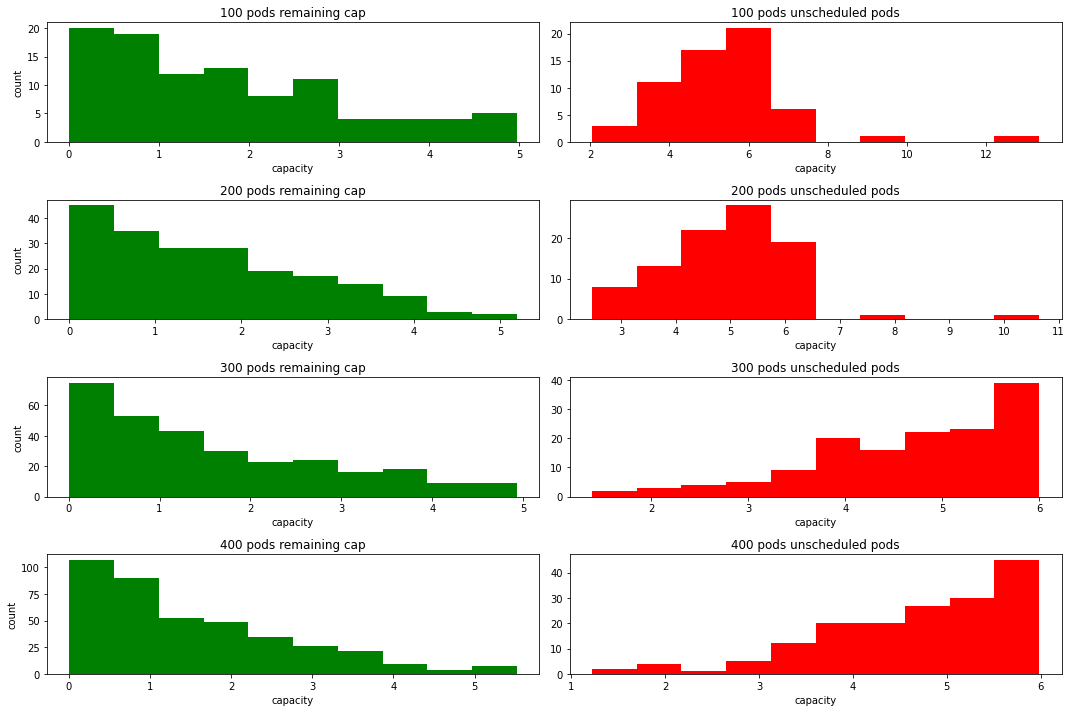

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(15, 10)


for i in range(len(dirs)):
  ax[i][0].hist(final_ws[i], color='green')
  ax[i][1].hist(left_elements[i], color='red')
  ax[i][0].set_title(f'{(i+1)*100} pods remaining cap')
  ax[i][1].set_title(f'{(i+1)*100} pods unscheduled pods')
  ax[i][0].set_xlabel('capacity')
  ax[i][1].set_xlabel('capacity')
  ax[i][0].set_ylabel('count')
  # ax.axhline(sl)

fig.tight_layout()
# fig.savefig(f'{graph_dir}finalw-2c-gaussian.png')

## Time taken

In [9]:
# dirs = ['data/2022-08-15T14-59-24', 'data/2022-08-15T15-02-56', 'data/2022-08-15T15-08-12',
#   'data/2022-08-15T15-15-12', 'data/2022-08-15T15-46-44', 'data/2022-08-15T15-51-43']
# ---- uniform distribtuion ---- #
# dirs = ['data/2022-08-15T16-00-21', 'data/2022-08-15T16-04-29', 'data/2022-08-15T16-06-44',
#   'data/2022-08-15T16-10-19', 'data/2022-08-15T16-16-32']
# ---- gaussian distribution ---- #
dirs = ['data/2022-08-16T11-19-32', 'data/2022-08-16T11-23-20', 'data/2022-08-16T11-27-08',
  'data/2022-08-16T11-31-12']

pods = range(100, (len(dirs) + 1) * 100, 100)

metrics = {}
runs = range(10)

for i, dir in enumerate(dirs):
  with open(f'{dir}/consensus-{pods[i]}pods.json', 'r') as f:
    for line in f:
      metrics[pods[i]] = json.loads(line)
x = pods
y_time = []
y_setup = []

for p in pods:
  t1 = []
  for r in runs:
    r = str(r)
    t2 = np.array([metrics[p][r][name]['total time'] for name in metrics[p][r]])
  t1.append(np.mean(t2))

  y_time.append([np.mean(t2), np.std(t2)])

  t2 = np.array([metrics[p]['0'][name]['setup time'] for name in metrics[p][r]])
  y_setup.append(np.mean(t2))


y_time = np.array(y_time)


pl_times = []
jobs_size = []
for i, dir in enumerate(dirs):
  with open(f'{dir}/placement-{pods[i]}pods-60cap-2c.json', 'r') as f:
    for l in f:
      pl = json.loads(l)
      ts = []
      js = []
      for j in runs:
        ts.append(pl[str(j)]['my-controller']['time taken'])
        js.append(pl[str(j)]['my-controller']['generated jobs size'])
      ts = np.array(ts)
      js = np.array(js)
      if (i == 3):
        print(ts)
      pl_times.append([np.mean(ts), np.std(ts)])
      jobs_size.append([np.mean(js), np.std(js)])

pl_times = np.array(pl_times)
jobs_size = np.array(jobs_size)



KeyError: 'generated jobs size'

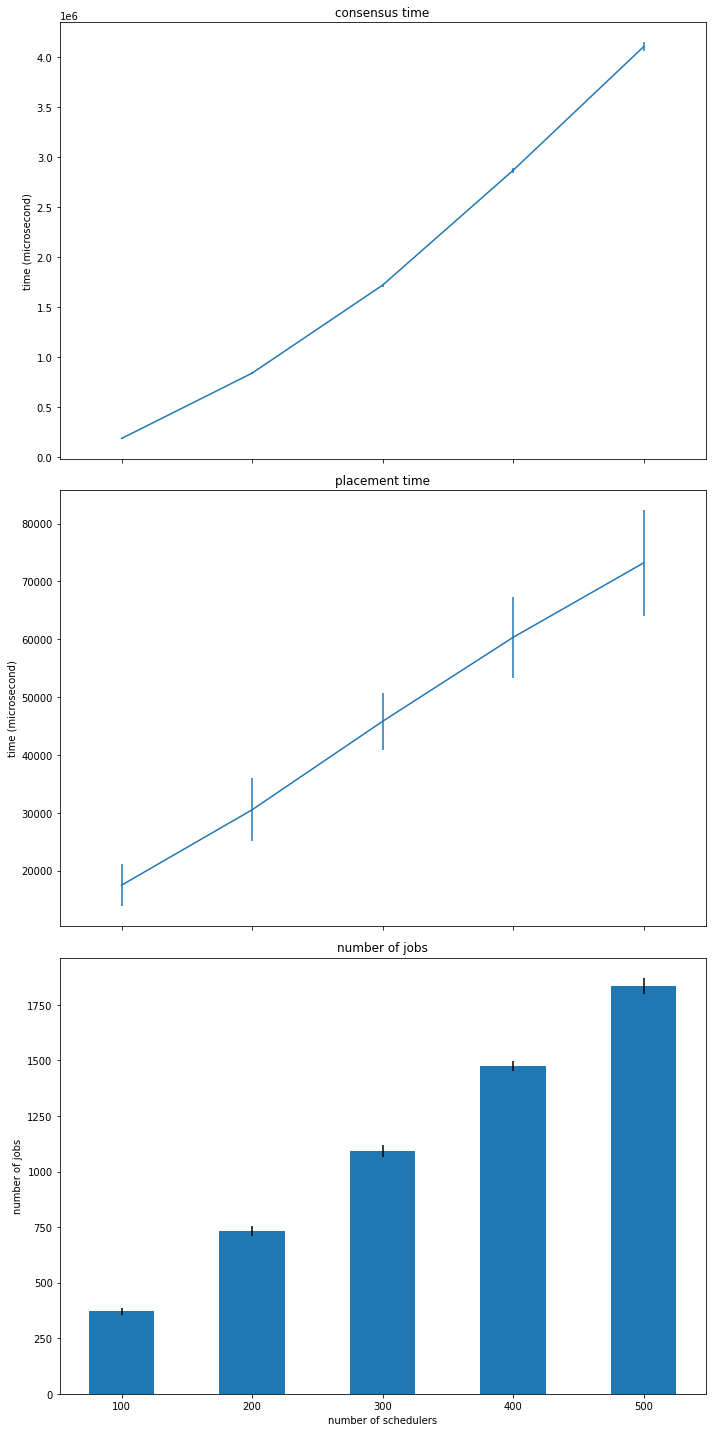

In [60]:
# -------- latency --------- #
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
fig.set_size_inches(10, 20)


ax[0].errorbar(x, y_time[:, 0], yerr = y_time[:, 1], label='consensus time')
ax[0].set_title('consensus time')
ax[0].set_ylabel('time (microsecond)')
ax[1].errorbar(pods, pl_times[:,0], yerr = pl_times[:,1], label='placement time')
ax[1].set_title('placement time')
ax[1].set_ylabel('time (microsecond)')


ax[2].bar(x, jobs_size[:, 0], width= 50,yerr = jobs_size[:, 1])
ax[2].set_ylabel("number of jobs")
ax[2].set_title("number of jobs")
ax[2].set_xlabel('number of schedulers')

fig.tight_layout()
fig.savefig(f'{graph_dir}latency-both.png')